In [1]:
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a312183/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [2]:
try:
   import viskex
except ImportError:
   !pip3 install "viskex@git+https://github.com/viskex/viskex.git@64c23fe"
   import viskex

  Cloning https://github.com/viskex/viskex.git (to revision 64c23fe) to /tmp/pip-install-xmai5x41/viskex_cf6bfc8c37304465b89b676725dfa8e5
  Running command git clone --filter=blob:none --quiet https://github.com/viskex/viskex.git /tmp/pip-install-xmai5x41/viskex_cf6bfc8c37304465b89b676725dfa8e5
  Running command git checkout -q 64c23fe
  Resolved https://github.com/viskex/viskex.git to commit 64c23fe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for pyvista[jupyter] from https://files.pythonhosted.org/packages/90/89/46a557b76052ec8aeab6b1d82847d136ad286185abd4d7ee92c7d352de71/pyvista-0.43.9-py3-none-any.whl.metadata
  Obtaining dependency information for pooch from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for scooby>=0.5.1 from

ModuleNotFoundError: No module named 'viskex'

In [3]:
import basix.ufl
import dolfinx.fem
import dolfinx.fem.petsc
import dolfinx.io
# import viskex
import mpi4py.MPI
import numpy as np
import numpy.typing
import petsc4py.PETSc
import ufl
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import matplotlib.pyplot as plt

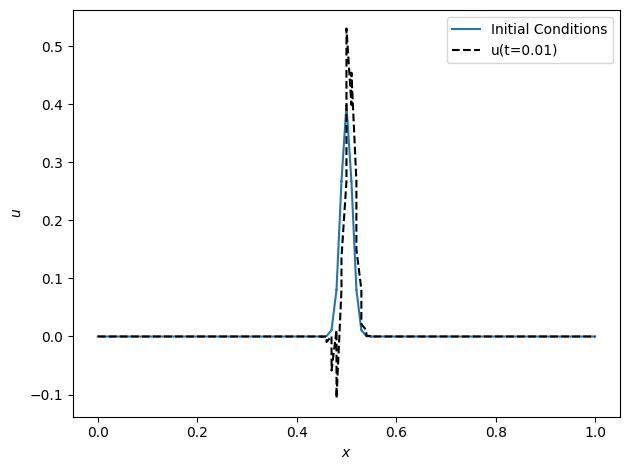

In [4]:
# 1d case

#Create mesh
nx = 100
Lx = 1.0
domain = dolfinx.mesh.create_interval(comm=MPI.COMM_WORLD, points=(0.0,Lx), nx=nx)

#Timestepping
CFL = 1.0
dt = CFL*(Lx/nx)/(1.0)

#Define function space
T_element = basix.ufl.element("DG", domain.basix_cell(), 1)
V = dolfinx.fem.functionspace(domain, T_element)

#No treatment of BCs are needed

#Define initial condition
def initial_condition(x):
    return (1/(np.sqrt(2*np.pi)))*np.exp(-((x[0]-0.5)**2)/0.00025)

u0 = dolfinx.fem.Function(V)
u0.interpolate(initial_condition)

#Store u0
u0_vals = u0.x.array.real

#Define solution variable
uh = dolfinx.fem.Function(V)
uh.interpolate(initial_condition)

#Define model equations
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

#Velocity vector
vel = dolfinx.fem.Constant(domain, PETSc.ScalarType((1.0,)))

#Midpoint solution
u_mid = 0.5*(u0 + u)


#Define equation
F = v*(u - u0)*ufl.dx + dt*v*ufl.dot(vel, ufl.grad(u_mid))*ufl.dx

#SUPG Stabilization Term
vnorm = ufl.sqrt(ufl.dot(vel,vel))
tdim = domain.topology.dim
num_cells = domain.topology.index_map(tdim).size_local
cells = np.arange(num_cells, dtype=np.int32)
meshcpp = dolfinx.cpp.mesh.Mesh_float64(domain.comm, domain.topology, domain.geometry)
h = dolfinx.cpp.mesh.h(meshcpp, tdim, cells)

res = u - u0 + dt*ufl.dot(vel, ufl.grad(u_mid))
stab = (h[0]/(2.0*vnorm))*ufl.dot(vel, ufl.grad(v))*res*ufl.dx

F += stab

a = ufl.lhs(F)
L = ufl.rhs(F)

#Setup solver
problem = dolfinx.fem.petsc.LinearProblem(a,L,
                                  petsc_options={"ksp_type": "preonly", "pc_type": "lu"})



#Solve
Tend = 1*dt
t = 0.0

while t < Tend - 1e-8:
    t += dt
    uh = problem.solve()
    u0.x.array[:] = uh.x.array

uh_vals = uh.x.array

#Plot
cells, types, x = dolfinx.plot.vtk_mesh(V)

#Plot IC
def ic(x):
    return (1/(np.sqrt(2*np.pi)))*np.exp(-((x-0.5)**2)/0.00025)

fig1,ax1 = plt.subplots(1,1,num=1)
ax1.plot(x[:,0],ic(x[:,0]),label="Initial Conditions")
ax1.plot(x[:,0],uh_vals,"--k",label="u(t=%s)"%t)
ax1.set_ylabel(r"$u$")
ax1.set_xlabel(r"$x$")
ax1.legend()
fig1.tight_layout()

plt.show()

In [5]:
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 20, 20)

# Create connectivities required by the rest of the code
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)

In [6]:
# Define the Function Space for the Temperature
T_element = basix.ufl.element("DG", mesh.basix_cell(), 1)
Ts = dolfinx.fem.functionspace(mesh, T_element)

V_element = basix.ufl.element("Lagrange", mesh.basix_cell(), 2, shape=(mesh.geometry.dim,))
V = dolfinx.fem.functionspace(mesh, V_element)

u = dolfinx.fem.Function(V,name="velocity")

T_n = dolfinx.fem.Function(Ts,name="temperature")
T = ufl.TrialFunction(Ts)
S = ufl.TestFunction(Ts)


$\frac{d T}{d t} +  \mathbf{u}\cdot\nabla T = 0$

Galerkin Discretization. Introduce the test function S and inner product $(T,S)=\int_{\Omega} T \cdot S dx $

$(\frac{d T}{d t},S) +  (\mathbf{u}\cdot\nabla (\frac{T+T_n}{2}),S) = 0$

Semi-Implicit scheme
$(T - T_n ,S) +  dt*(\mathbf{u}\cdot\nabla (\frac{T+T_n}{2}),S) = 0 $

Residual  is defined by

$ \mathrm{residual} = T - T_n  +  dt*(\mathbf{u}\cdot\nabla (\frac{T+T_n}{2})) $

The week form is
$(T - T_n ,S) +  dt*(\mathbf{u}\cdot\nabla (\frac{T+T_n}{2}),S) = 0 $
where $T_n$ is Temperature at previous time step.
To ensure  numerical stability, we add SUPG part (see Quarteroni Chapter 13, Consistent SUPG-method for transient transport problems: Stability
and convergence).

The supg formulation led to replace the test function S with
$W= S + \alpha \cdot   (\mathbf{u}, \nabla S)$, where $ \alpha = \frac{|h|}{2 \cdot \sqrt{(\mathbf{u},\mathbf{u})} } $

Thus the former weak form will be replaced by

$(T - T_n ,S) +  dt*(\mathbf{u}\cdot\nabla (\frac{T+T_n}{2}),S) +  \alpha \cdot   (\mathbf{u}, \nabla S) * residual  = 0 $





In [7]:
from dolfinx.fem.petsc import LinearProblem



def u_eval(x: np.typing.NDArray[np.float64]) -> np.typing.NDArray[  # type: ignore[no-any-unimported]
        petsc4py.PETSc.ScalarType]:
    """Return the flat velocity profile at the inlet."""
    values = np.zeros((2, x.shape[1]))
    values[0, :] = np.sin(np.pi*x[0])
    values[1, :] = -np.pi*x[1]* np.cos(np.pi*x[1])
    return values

u.interpolate(u_eval)

# Initial Condition
T_n = dolfinx.fem.Function(Ts)
T_n.interpolate(lambda x: np.exp(-1e2*((x[0]-0.5)**2+(x[1]-0.5)**2)) )


mid_point = (T+T_n)*0.5

F = ufl.dot(T - T_n, S)*ufl.dx +  dt*ufl.dot(ufl.dot(u,ufl.grad(mid_point)),S)*ufl.dx
residual = T  - T_n  + dt * ufl.dot(u,ufl.grad(mid_point))

h = ufl.CellDiameter(mesh)
alpha = h /(2*(ufl.sqrt(ufl.dot(u,u))))

F+= alpha*ufl.dot(u,ufl.grad(S))*residual*ufl.dx

A = ufl.lhs(F)
L = ufl.rhs(F)

#Timestepping


tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
cells = np.arange(num_cells, dtype=np.int32)
meshcpp = dolfinx.cpp.mesh.Mesh_float64(mesh.comm, mesh.topology, mesh.geometry)
h = dolfinx.cpp.mesh.h(meshcpp, tdim, cells)

print(h.max())
magnitude_pointwise = dolfinx.fem.form(ufl.sqrt(ufl.dot(u,u))* ufl.dx)

magnitude_total = np.sqrt(mesh.comm.allreduce(dolfinx.fem.assemble_scalar(magnitude_pointwise), MPI.SUM))
print(magnitude_total)

CFL = 1.0
dt = CFL*(h.max())/magnitude_total
print(dt)



fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
bc_D = dolfinx.fem.dirichletbc(PETSc.ScalarType(0.), dolfinx.fem.locate_dofs_topological(Ts, fdim, boundary_facets),Ts)

t = 0


problem = LinearProblem(A,L,bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

num_dt=10

for n in range(num_dt):
    t+=dt

    Th = problem.solve()
    Th.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = Th.x.array

    T_n.name="temperature"


T_n.x.array

0.07071067811865482
1.14243699870102
0.06189459742555141


array([3.03897834e-20, 2.21105884e-22, 3.04320066e-20, ...,
       1.31430545e-19, 1.16216859e-19, 1.32373333e-19])

In [8]:
viskex.dolfinx.plot_vector_field(u, "vel")

NameError: name 'viskex' is not defined

In [9]:
T_0 = dolfinx.fem.Function(Ts)
T_0.interpolate(lambda x: np.exp(-1e2*((x[0]-0.5)**2+(x[1]-0.5)**2)) )
viskex.dolfinx.plot_vector_field(T_0, "T")
viskex.dolfinx.plot_vector_field(T_n, "T")

NameError: name 'viskex' is not defined

In [10]:
!pip3 install git+https://github.com/viskex/viskex.git@64c23fe -v

Using pip 23.2.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Cloning https://github.com/viskex/viskex.git (to revision 64c23fe) to /tmp/pip-req-build-bxxxguq9
  Running command git version
  git version 2.34.1
  Running command git clone --filter=blob:none https://github.com/viskex/viskex.git /tmp/pip-req-build-bxxxguq9
  Cloning into '/tmp/pip-req-build-bxxxguq9'...
  Running command git show-ref 64c23fe
  Running command git rev-parse HEAD
  dd04b14e43d8e0b4d77aaca227cd4a5a1f7df118
  Running command git checkout -q 64c23fe
  Resolved https://github.com/viskex/viskex.git to commit 64c23fe
  Running command git rev-parse HEAD
  64c23feae1279d8b88dfb20a4148e22291c0f875
  Running command pip subprocess to install build dependencies
    Obtaining dependency information for setuptools>=62 from https://files.pythonhosted.org/packages/de/88/70c5767a0e43eb4451c2200f07d042a4bcd7639276003a9c54a68cfcc1f8/setuptools-70.0.0-py3-none-any.whl.metadata
    Using cached setuptools